# 2-Cell and 3-Cell Motifs in PyC Subgraph (Th=300)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_th300 = get_thresholded_graph(g_actual, axls, 300)
print(nx.info(g_th300))

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 622
Average in degree:   6.2200
Average out degree:   6.2200


### 2. Compare 2-Cell Motif Statistics (OBS vs ER vs CFG)

In [6]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_th300)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_th300)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.26 ms


In [7]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_two_counts = sample_motifs_parallel_continuous(continuous_sample_two_neuron_motifs, g_th300, samples=s, niters=int(1e4), threads=10)

CPU times: user 76 ms, sys: 56 ms, total: 132 ms
Wall time: 34 s


In [8]:
# save sampled motif counts from CFG model as intermediate data
config_two_counts.to_csv("saved/th300_2motif_cfg1000.csv", index=False)

In [9]:
# load precomputed sampled motif counts from CFG model
config_two_counts = pd.read_csv("saved/th300_2motif_cfg1000.csv")

connect probability =  0.06282828282828283


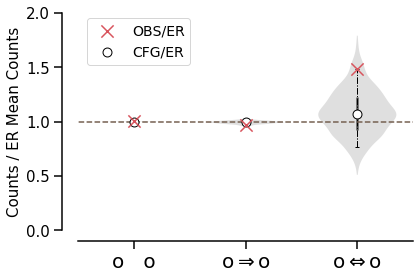

In [11]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2), fname="th300/th300_2_violin");

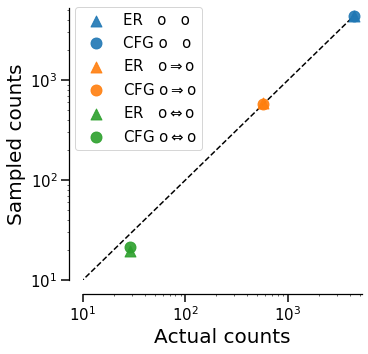

In [12]:
plot_two_neuron_counts_scatter(obs_two_counts, er_two_counts, config_two_counts, figsize=(5,5), fname="th300/th300_2_scatter")

In [13]:
res_two

,obs,er_exp,config_exp,config_std,proximity_z
actual_edges,NaN,NaN,622.000,0.000000,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,29.0,19.539596,21.305,4.158999,1.850205
neurons,NaN,NaN,100.000,0.000000,NaN
null,4357.0,4347.539596,4349.305,4.158999,1.850205
potential_edges,NaN,NaN,9900.000,0.000000,NaN
uni,564.0,582.920808,579.390,8.317998,-1.850205


In [14]:
# single side p-values
np.minimum((config_two_counts >= obs_two_counts).sum(0) / 1000, 
           (config_two_counts <= obs_two_counts).sum(0) / 1000)

neurons            1.000
autapses           1.000
actual_edges       1.000
uni                0.054
bi                 0.054
potential_edges    1.000
null               0.054
dtype: float64

### 2. Compare 3-Cell Motif Statistics (OBS vs gER vs CFG)

In [15]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_th300), motifs)
# analytically compute 2-cell motif counts in generalized Erdos-Renyi model
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th300)
er_three_counts_GE = compute_expected_three_neuron_motifs(g_th300, three_pr_GE)

CPU times: user 12 s, sys: 24 ms, total: 12 s
Wall time: 12 s


In [16]:
%%time
# sample graphs from CFG model and compute 3-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs, g_th300, samples=s, niters=int(1e4), threads=10)

CPU times: user 124 ms, sys: 84 ms, total: 208 ms
Wall time: 37min 56s


In [17]:
# save sampled motif counts from CFG model as intermediate data
config_three_counts.to_csv("saved/th300_3motif_cfg1000.csv", index=False)

In [18]:
# load precomputed sampled motif counts from CFG model
config_three_counts = pd.read_csv("saved/th300_3motif_cfg1000.csv")
config_three_counts.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

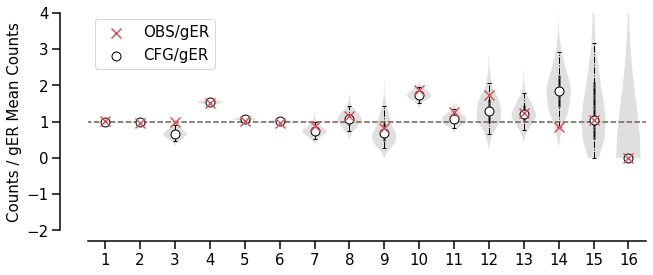

In [25]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-2, 4], er_name="gER", fname="th300/th300_3_violin", figsize=(10,4))

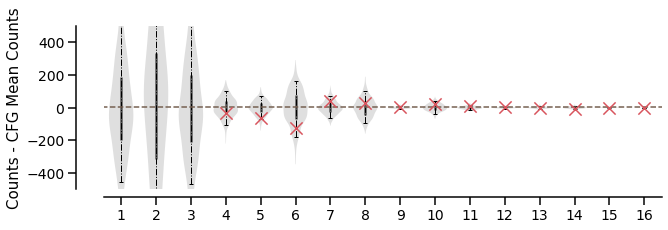

In [20]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], er_name="gER", fname="th300/th300_3_violin_diff");

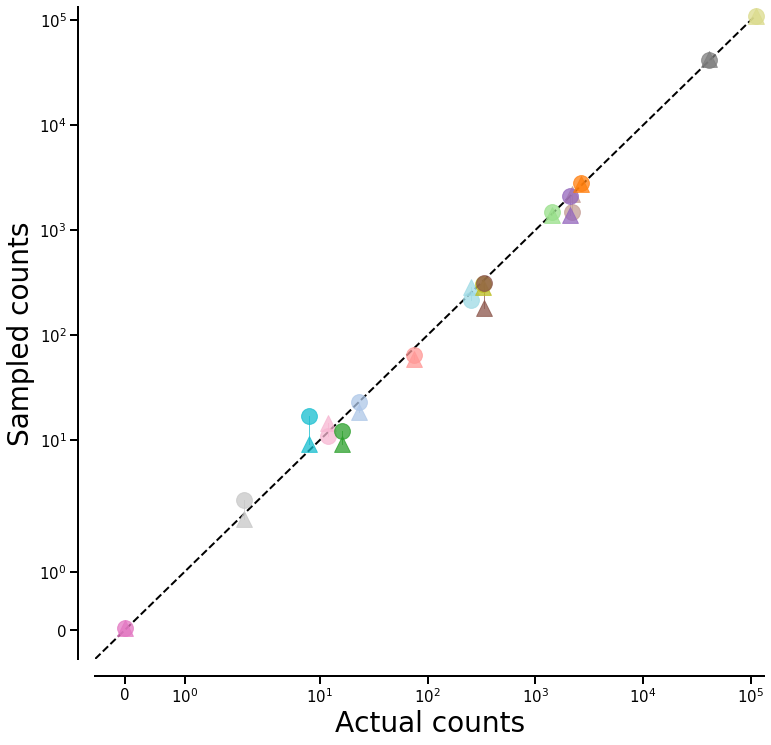

In [21]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, figsize=(12,12), fname="th300/th300_3_scatter")

In [22]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,111292,110269.931024,110636.992,289.313308,2.264009
2,40979,42822.291322,42198.917,487.363254,-2.503096
3,2182,2201.855405,1490.119,299.852484,2.307405
4,2100,1385.802864,2133.859,63.094533,-0.536639
5,1427,1385.802864,1489.293,43.683262,-1.426015
6,2664,2771.605727,2790.514,106.259441,-1.190614
7,255,285.023284,213.766,41.133407,1.002446
8,330,285.023284,304.410,59.823145,0.427761
9,12,14.655453,11.000,5.368876,0.186259
10,335,179.387839,312.098,23.278408,0.983830


In [23]:
# one side p-values
np.minimum((config_three_counts >= obs_three_counts).sum(0) / 1000, 
           (config_three_counts <= obs_three_counts).sum(0) / 1000)

1     0.022
2     0.011
3     0.017
4     0.289
5     0.085
6     0.128
7     0.168
8     0.325
9     0.393
10    0.180
11    0.133
12    0.197
13    0.500
14    0.059
15    0.534
16    0.961
dtype: float64

### 4. Clustering Coefficient

In [30]:
# compute connection probability in ER
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_th300)

In [31]:
%%time
# sample graphs from generalized CFG (gCFG) model and compute 3-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts_GE = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs_GE, g_th300, samples=s, niters=int(1e4), threads=10)

CPU times: user 108 ms, sys: 72 ms, total: 180 ms
Wall time: 36min 43s


In [32]:
# save sampled motif counts from gCFG model as intermediate data
config_three_counts_GE.to_csv("saved/th300_3motif_gcfg1000.csv", index=False)

In [33]:
# load precomputed sampled motif counts from gCFG model
config_three_counts_GE = pd.read_csv("saved/th300_3motif_gcfg1000.csv")
config_three_counts_GE.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

In [34]:
# clustering coefficient of the observed network
nx.transitivity(g_th300.to_undirected())

0.16864666258420086

In [35]:
# expected clustering coefficient of the networsk sampled from the ER model
1-two_pr['pr_null']

0.12170917253341484

In [36]:
# expected clustering coefficient of the networsk sampled from the CFG model
clustering_coef(config_three_counts).mean()

0.15700401120338445

In [37]:
# expected clustering coefficient of the networsk sampled from the generalized ER model
1-two_pr_GE['pr_null']

0.11979797979797979

In [38]:
# expected clustering coefficient of the networsk sampled from the generalized CFG model
clustering_coef(config_three_counts_GE).mean()

0.1543461294132122

In [39]:
# p-value: CFG vs OBS
(clustering_coef(config_three_counts) >= nx.transitivity(g_th300.to_undirected())).sum()/1000

0.04

### 5. Generate Smaller Plots for Pannels

connect probability =  0.06282828282828283


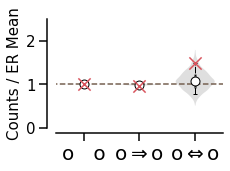

In [26]:
plot_two_neuron_counts_violin_adapt(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2.5), figsize=(3,2), fname="th300/th300_2_violin");

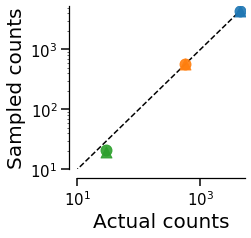

In [27]:
plot_two_neuron_counts_scatter_adapt(obs_two_counts, er_two_counts, config_two_counts, figsize=(3,3), fname="th300/th300_2_scatter");

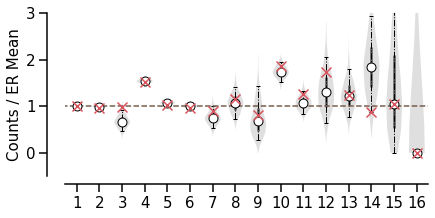

In [28]:
res_three_CGE = plot_three_neuron_counts_violin_adapt(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-0.5, 3], fname="th300/th300_3_violin_CGE", figsize=(6.5,3))

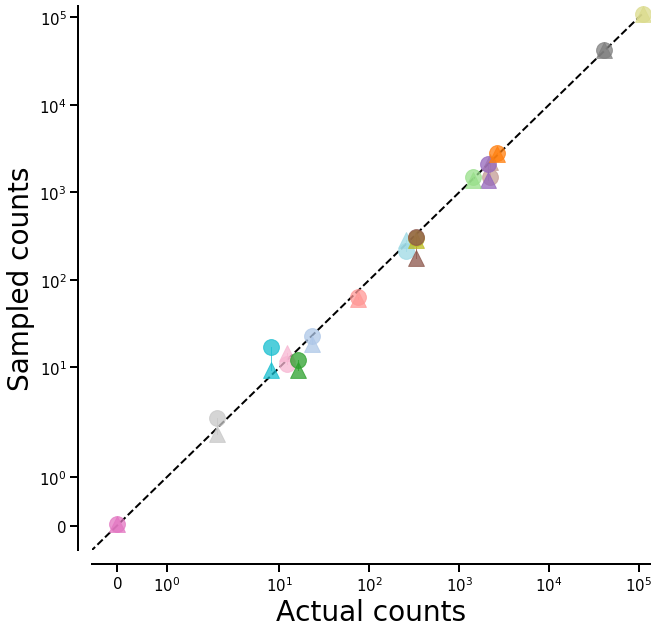

In [29]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                 figsize=(10,10), fname="th300/th300_3_scatter_CGE")